# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook six - Machine Learning - level 1 modells

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this notebook we build a framework to choose the best performing algorythms later. 

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..') # r'C:\WQU\Capstone\Working_files'
sys.path.append(path_to_project)

In [2]:
from WQUcapstoneCode.ml.ml import cv_with_custom_score

C:\Users\astar\Anaconda3\lib\site-packages\pyfolio\pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [5]:
# Instrall the latest lightgbm, xgboost and sklearn
!pip install --upgrade lightgbm
!pip install --upgrade xgboost
!pip install --upgrade sklearn

Requirement already up-to-date: lightgbm in c:\users\astar\anaconda3\lib\site-packages (2.3.1)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Requirement already up-to-date: xgboost in c:\users\astar\anaconda3\lib\site-packages (1.1.1)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Requirement already up-to-date: sklearn in c:\users\astar\anaconda3\lib\site-packages (0.0)


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve

from lightgbm import LGBMClassifier

from xgboost import XGBClassifier

Here we will use AUDUSD pair as illustration.

In [6]:
ticker = 'AUD/USD'

In [7]:
preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
#data.index = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in data.index]

Preprocessed data sample

In [8]:
data.head(10)

,price,fast,slow,ema_side,average,upper_band,lower_band,standard_deviation,bb_side,%K,...,lower_band_frdif,upper_band_frdif,kijun_sen_frdif,tenka_sen_frdif,senkou_span_b_frdif,senkou_span_a_frdif,price_frdif,volatility,ret,bin
2015-07-02 07:00:00,0.760495,0.764272,0.766210,-1.0,0.767834,0.774169,0.761498,0.003168,1.0,0.000000,...,0.035746,0.038201,0.035973,0.035413,0.037777,0.035700,0.032281,0.006633,-0.008725,-1.0
2015-07-03 01:00:00,0.758435,0.761909,0.763663,-1.0,0.765871,0.774348,0.757393,0.004239,1.0,0.000000,...,0.034410,0.037873,0.035993,0.034111,0.037742,0.037103,0.031332,0.006786,-0.008551,-1.0
2015-07-03 09:00:00,0.751950,0.757411,0.760619,-1.0,0.763539,0.774360,0.752718,0.005411,1.0,0.000000,...,0.031788,0.038019,0.034156,0.032481,0.037280,0.037055,0.029136,0.006966,-0.010779,-1.0
2015-07-06 13:00:00,0.752895,0.751288,0.753730,-1.0,0.755802,0.766518,0.745085,0.005358,1.0,31.874405,...,0.031267,0.033938,0.034137,0.031291,0.037078,0.037612,0.035547,0.006915,-0.012020,-1.0
2015-07-06 23:00:00,0.747850,0.750238,0.752389,-1.0,0.754067,0.764342,0.743792,0.005138,1.0,0.000000,...,0.031104,0.033595,0.032722,0.032204,0.036779,0.037280,0.030294,0.006732,-0.007114,-1.0
2015-07-07 09:00:00,0.743530,0.747102,0.749964,-1.0,0.751465,0.760642,0.742288,0.004588,1.0,0.000000,...,0.030957,0.031816,0.032096,0.031292,0.037039,0.037363,0.029022,0.006681,-0.006866,-1.0
2015-07-08 05:00:00,0.738425,0.742374,0.745162,-1.0,0.746762,0.754939,0.738584,0.004089,1.0,0.000000,...,0.029926,0.031586,0.029138,0.027992,0.037018,0.035791,0.027027,0.006784,0.007205,1.0
2015-07-08 13:00:00,0.743745,0.742305,0.743880,-1.0,0.745056,0.753017,0.737095,0.003980,1.0,36.765722,...,0.030661,0.031141,0.030509,0.030625,0.033976,0.033318,0.033499,0.006647,0.006669,1.0
2015-07-09 01:00:00,0.745840,0.743026,0.743607,-1.0,0.743501,0.749022,0.737980,0.002761,1.0,64.310494,...,0.032282,0.029425,0.031685,0.032038,0.035054,0.034467,0.036154,0.006513,-0.009881,-1.0
2015-07-09 09:00:00,0.742970,0.744161,0.744147,1.0,0.743012,0.747196,0.738827,0.002092,1.0,47.368421,...,0.032866,0.029546,0.032162,0.033096,0.033879,0.032271,0.031080,0.006811,0.007719,1.0


We need to split the data into training, validation and test sets. We may try using "purged k-fold cross validation", as in the book, however, our data is already not dense, so we may use just a regular cross validation to choose best modells.

In [9]:
# We remove the last 2 columns as the return data and indicator for this is a positive or negative return. 
all_feature_cols = data.columns[:-2] 

In [10]:
# Here we split the features columns when they were applied fractional difference
frdif_feature_dict = {c[:-6]:c for c in all_feature_cols if c[-5:]=='frdif'}

In [11]:
# Here we split the features columns when they were NOT applied fractional difference
ex_frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.values()]

In [12]:
# Here we extract the features columns when they were applied fractional difference 
frdiff_cols = [c for c in all_feature_cols if c not in frdif_feature_dict.keys()]

In [13]:
# Here we extract the features columns for EMA / Bollinger Bands / Stochasticss / William % R / Ichimoku / Relative Strength Index
side_cols = [c for c in all_feature_cols if c[-4:]=='side']

In [14]:
# split the data into 3 parts: ~50%, 25%, 25%
n = len(data)
train_ids, valid_ids, test_ids = (0, int(np.floor(n/2))), (int(np.ceil(n/2)), int(np.floor(n/2+n/4))), (int(np.ceil(n/2+n/4)), n)
train_ids, valid_ids, test_ids #For checking number of rows

((0, 476), (476, 714), (714, 952))

In [15]:
X_train = data[all_feature_cols].iloc[train_ids[0]:train_ids[1],:]
X_valid = data[all_feature_cols].iloc[valid_ids[0]:valid_ids[1],:]
X_test = data[all_feature_cols].iloc[test_ids[0]:test_ids[1],:]

Y_train = data.bin.iloc[train_ids[0]:train_ids[1]]
Y_valid = data.bin.iloc[valid_ids[0]:valid_ids[1]]
Y_test = data.bin.iloc[test_ids[0]:test_ids[1]]

target_rtns_train, target_rtns_valid, target_rtns_test = data.ret.iloc[train_ids[0]:train_ids[1]], data.ret.iloc[valid_ids[0]:valid_ids[1]], \
                                        data.ret.iloc[test_ids[0]:test_ids[1]]
print(Y_train.value_counts())
print(Y_valid.value_counts())
print(Y_test.value_counts())

 1.0    212
-1.0    211
 0.0     53
Name: bin, dtype: int64
-1.0    105
 1.0     93
 0.0     40
Name: bin, dtype: int64
 1.0    108
-1.0     98
 0.0     32
Name: bin, dtype: int64


# Tuning RandomForest

We will use Random Forest to select features that are important. Later we will tune other algorythms(as well) using different feature sets.

In [16]:
cols = all_feature_cols
RANDOM_STATE = 1
rfc = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', .3, .1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 8, num = 7)]#[int(x) for x in np.linspace(1, 40, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
cv = KFold(n_splits=4, shuffle=False)
search = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                            n_iter = 100, cv = cv, verbose=1, random_state=RANDOM_STATE, 
                            n_jobs = cpu_count()-1)
search.fit(X_train[cols],Y_train)
rfc = search.best_estimator_
print(f'Best parameters:/n{search.best_params_}')

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  4.4min
[Parallel(n_jobs=3)]: Done 400 out of 400 | elapsed:  8.9min finished


Best parameters:/n{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


After finding the best parameters to be used in random forest, we look at the importance score to see which features would be important for forecasting returns.

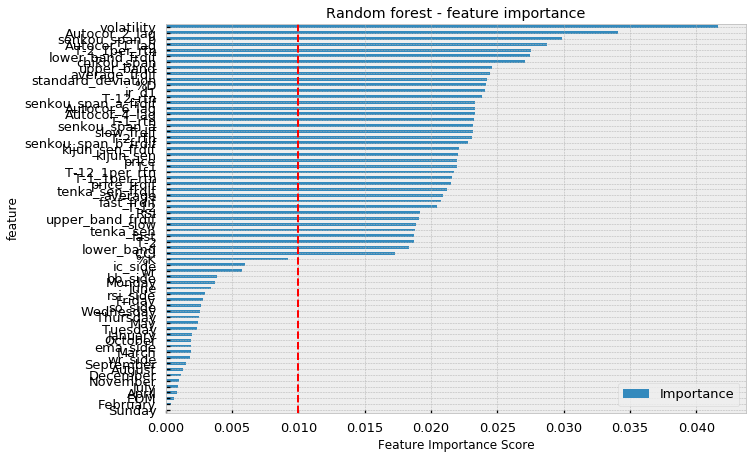

In [18]:
# We get the importance score from model trained
feat_imp = pd.DataFrame({'Importance':rfc.feature_importances_})    

# Get the feature name from the trading set column name
feat_imp['feature'] = X_train[cols].columns

# Sort the features by the importance
feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)

# Plot horizontal bar chart by the importance score
feat_imp[feat_imp.Importance>0].plot.barh(title='Random forest - feature importance')
plt.xlabel('Feature Importance Score')
plt.axvline(0.01, color='r', ls='--') # Add an vertical red dotted line
plt.show()

We can select top features that Random Forest assumes to be important with score larger than 0.01.

In [19]:
top_feat = feat_imp[feat_imp.Importance>0.01].index
top_feat

Index(['CCI', 'lower_band', 'T-2', 'fast', 'tenka_sen', 'slow',
       'upper_band_frdif', 'RSI', 'T-12', 'fast_frdif', 'average',
       'tenka_sen_frdif', 'price_frdif', 'T-1_1per_rtn', 'T-12_1per_rtn',
       'T-1', 'price', 'kijun_sen', 'kijun_sen_frdif', 'senkou_span_b_frdif',
       'T-2_rtn', 'slow_frdif', 'senkou_span_a', 'T-1_rtn', 'Autocor_4_lag',
       'Autocor_6_lag', 'senkou_span_a_frdif', 'T-12_rtn', 'ir_d1', '%D',
       'standard_deviation', 'average_frdif', 'upper_band', 'chikou_span',
       'lower_band_frdif', 'T-2_1per_rtn', 'Autocor_1_lag', 'senkou_span_b',
       'Autocor_2_lag', 'volatility'],
      dtype='object', name='feature')

 # Tune other algorythms(as well) using different feature sets

Here we classify the feature set with all features used, features that are not using fractical differencing, features using fractical differencing and top features with relative importance score.

In [20]:
features = {'all_feature_cols':all_feature_cols, 
            'ex_frdiff_cols':ex_frdiff_cols,
            'frdiff_cols':frdiff_cols, 
            'top_feat_RF':top_feat}

Here we are using various classifiers. This includes:
1. LightGBM
2. XGBoost
3. Classifier from the turned Random Forest above.
4. Random Forest
5. ExtraTrees
6. Adaptive Boosting
7. Random Forest with 4 principal components of the features
8. Logistic Regression with 4 principal components of the features
9. Support Vector Machine
10. Support Vector Machine with 4 principal components of the features
11. Support Vector Machine with 20 principal components of the features
12. Naive Bayes classifier with 6 principal compoents of the features
12. Naive Bayes classifier

In [21]:
models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':rfc,
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   

Here we set up null dataframe to capture the accuracy score and its standard derivations, returns and Sharpe ratios.

In [22]:
score = pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
score_stds = pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
rtns =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
sharp =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())

In [23]:
n_splits = 5

Calculating accuracy scores using k-fold cross validation.

In [24]:
cv = KFold(n_splits=n_splits, shuffle=False)

for n,cols in features.items():
    for m,c in models.items():
        n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
        score.loc[n,m] = np.mean(n_scores)
        score_stds.loc[n,m] = np.std(n_scores)

Calculating cross-validated returns and sharp ratios.
Please note that these are arithmetically linked returns (for simplicity).

In [25]:
for n,cols in features.items():
    for m,c in models.items():
        r, sh = cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
        rtns.loc[n,m] = r
        sharp.loc[n,m] = sh

## Accuracy map of these algorythms

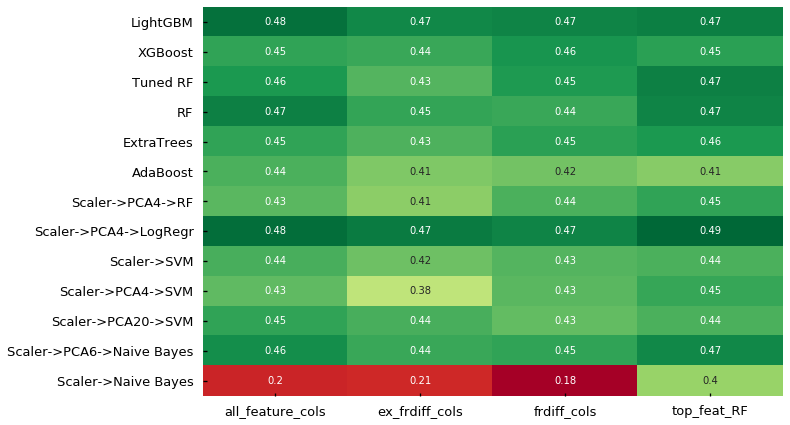

In [26]:
sns.heatmap(score.T,annot=True, cbar=False, cmap="RdYlGn")

Naive Bayes without PCA is showing the worst accuracy score and should not be used.

## Standard deviation of accuracy of these algorythms

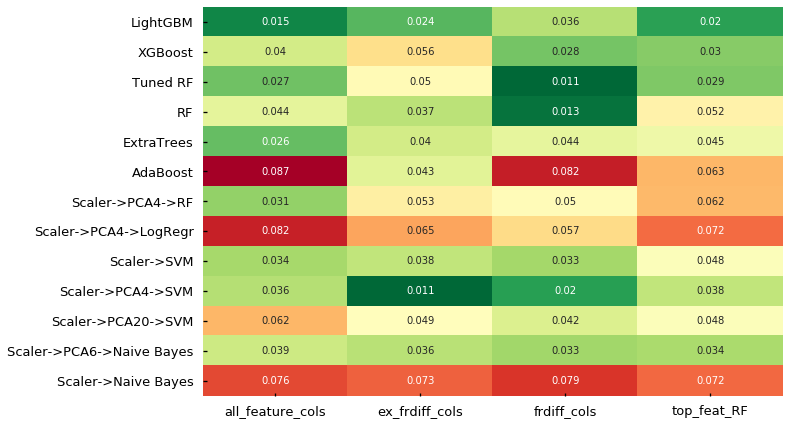

In [27]:
sns.heatmap(score_stds.T,annot=True, cbar=False, cmap="RdYlGn_r")

Algotythms trained on fractionally differentiated features show the lowest standard deviation of accuracy score.

___________________________________________
To check the performance of modells we will use bot validation and test results to make sure that the result is consistent.

## Cross-validated returns of the algorythms on the trainig set

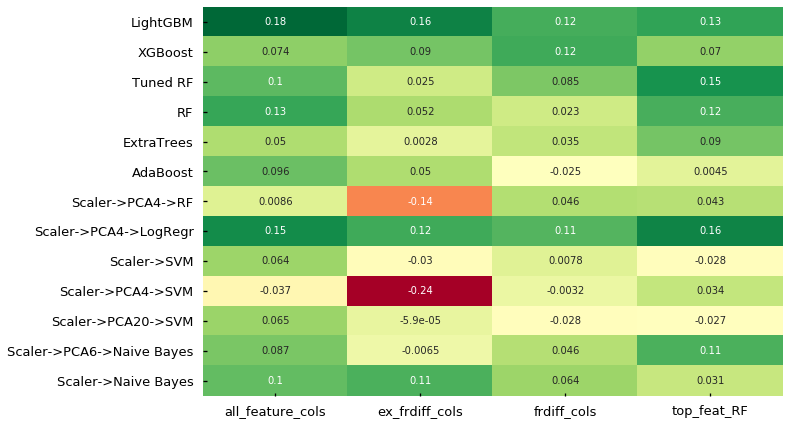

In [28]:
sns.heatmap(rtns.T,annot=True, cbar=False, cmap="RdYlGn")

Performance of SVM and Bayes is not good when we use features other than top features.

## Cross-validated volatility of returns of the algorythms on the traning set

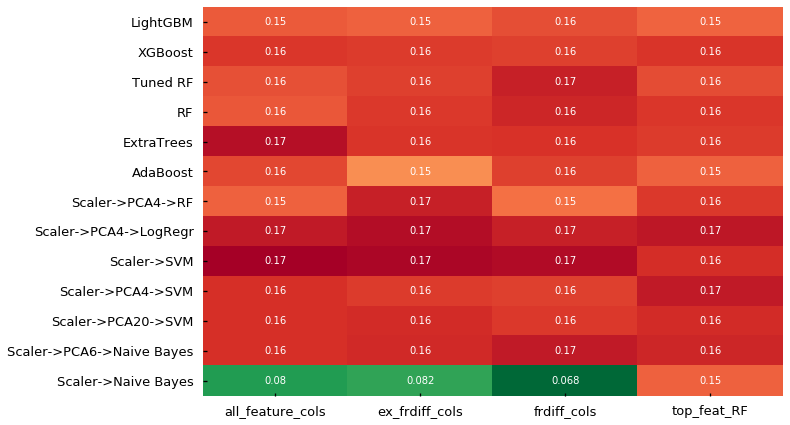

In [29]:
sns.heatmap((rtns/sharp).T,annot=True, cbar=False, cmap="RdYlGn_r")

## Sharp ratio - training set

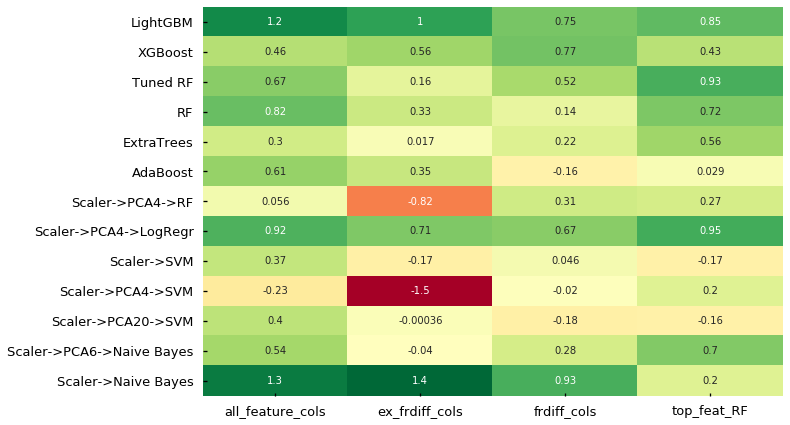

In [30]:
sns.heatmap(sharp.T,annot=True, cbar=False, cmap="RdYlGn")

### Running the same for the validation set
to make sure that the result holds

In [31]:
rtns_valid =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())
sharp_valid =  pd.DataFrame(np.nan, index=features.keys(), columns=models.keys())

for n,cols in features.items():
    #print('\n'+n)
    for m,c in models.items():
        rtn = c.fit(X_train[cols],Y_train).predict(X_valid[cols]) * target_rtns_valid
        days = np.busday_count(X_valid.index.min().date(),X_valid.index.max().date())
        rtns_valid.loc[n,m] = np.sum(rtn) * 252 /days
        vol = np.std(rtn.groupby(rtn.index.date).sum())*np.sqrt(252)
        sharp_valid.loc[n,m] = rtns_valid.loc[n,m] / vol

## Returns - validation set

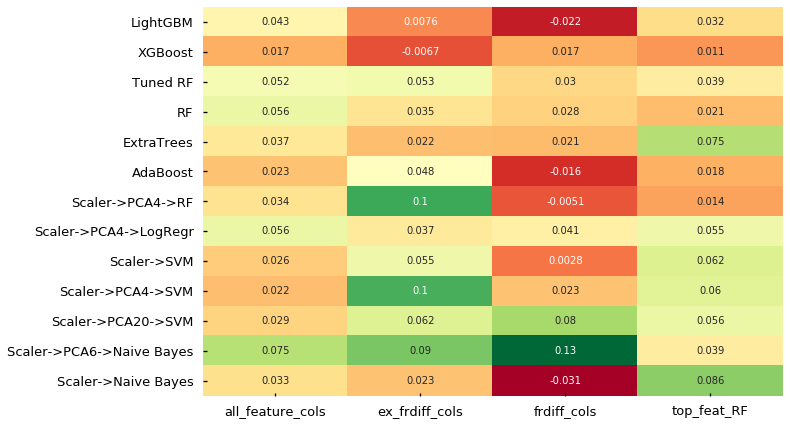

In [32]:
sns.heatmap(rtns_valid.T,annot=True, cbar=False, cmap="RdYlGn")

## Volatility - validation set

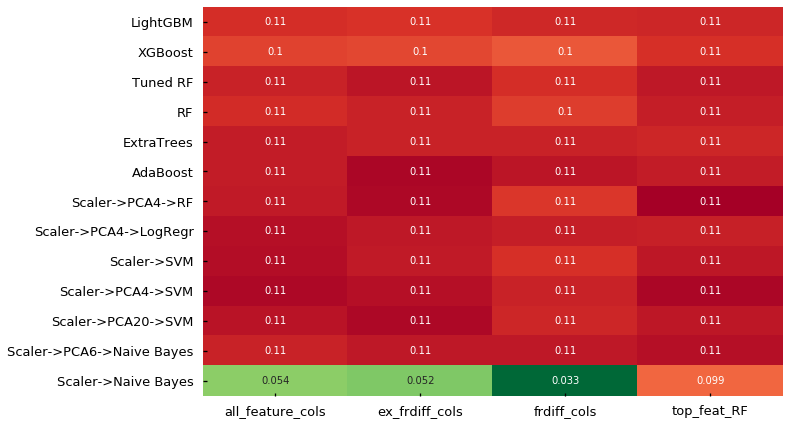

In [33]:
sns.heatmap((rtns_valid/sharp_valid).T,annot=True, cbar=False, cmap="RdYlGn_r")

## Sharp - validation set

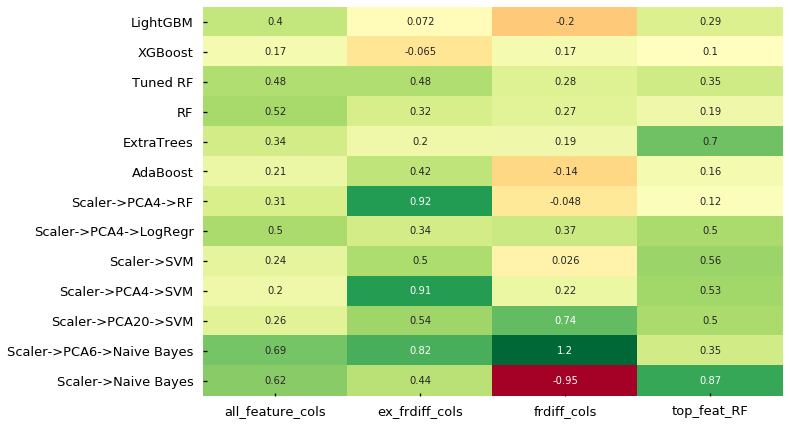

In [34]:
sns.heatmap(sharp_valid.T,annot=True, cbar=False, cmap="RdYlGn")

From the above we can see that it is hard to pick winners since the dispersion of results is high. It may be worth running the same for all currency pairs to understand what algorythms perform better that others on average. 

## Backtesting on validation data

------
Below is a simple example of applying these algorythms on the validation data

In [39]:
import pyfolio as pf

In [40]:
def get_pyfolio_simple_tear_sheet(mdl,X_tr, Y_tr, X_tst, Y_tst, rtns_actual):
    mdl.fit(X_tr, Y_tr)
    predicted_labels = pd.Series(mdl.predict(X_tst), index = Y_tst.index)
    rtns = predicted_labels * rtns_actual
    pf.create_simple_tear_sheet(rtns)

Start date,2017-05-18
End date,2019-01-04
Total months,11
,Backtest
Annual return,2.6%
Cumulative returns,2.4%
Annual volatility,9.8%
Sharpe ratio,0.31
Calmar ratio,0.24
Stability,0.65
Max drawdown,-10.6%


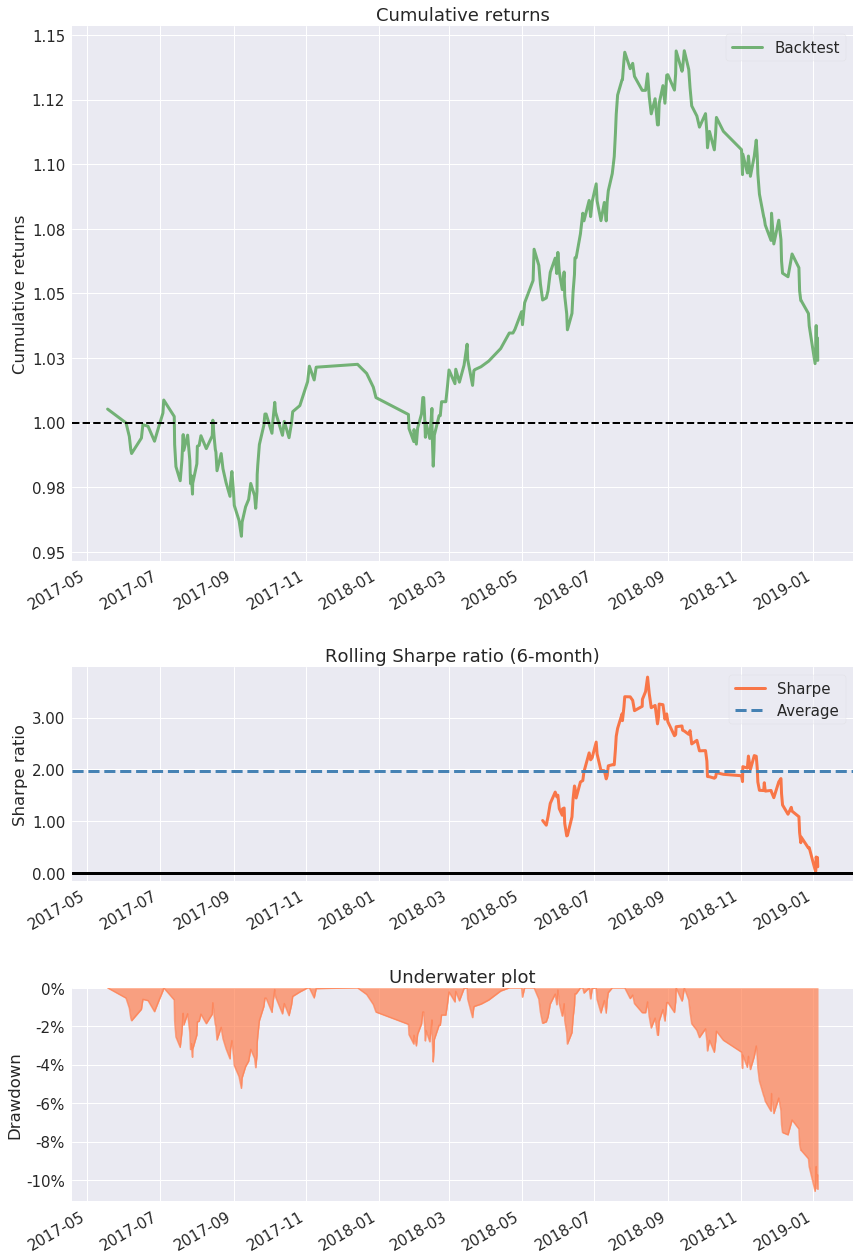

In [41]:
cols = features['frdiff_cols']
model = models['XGBoost']
validation = True
if validation:
    get_pyfolio_simple_tear_sheet(model,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    get_pyfolio_simple_tear_sheet(model,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

Start date,2017-05-18
End date,2019-01-04
Total months,11
,Backtest
Annual return,11.2%
Cumulative returns,10.5%
Annual volatility,10.0%
Sharpe ratio,1.11
Calmar ratio,1.36
Stability,0.69
Max drawdown,-8.2%


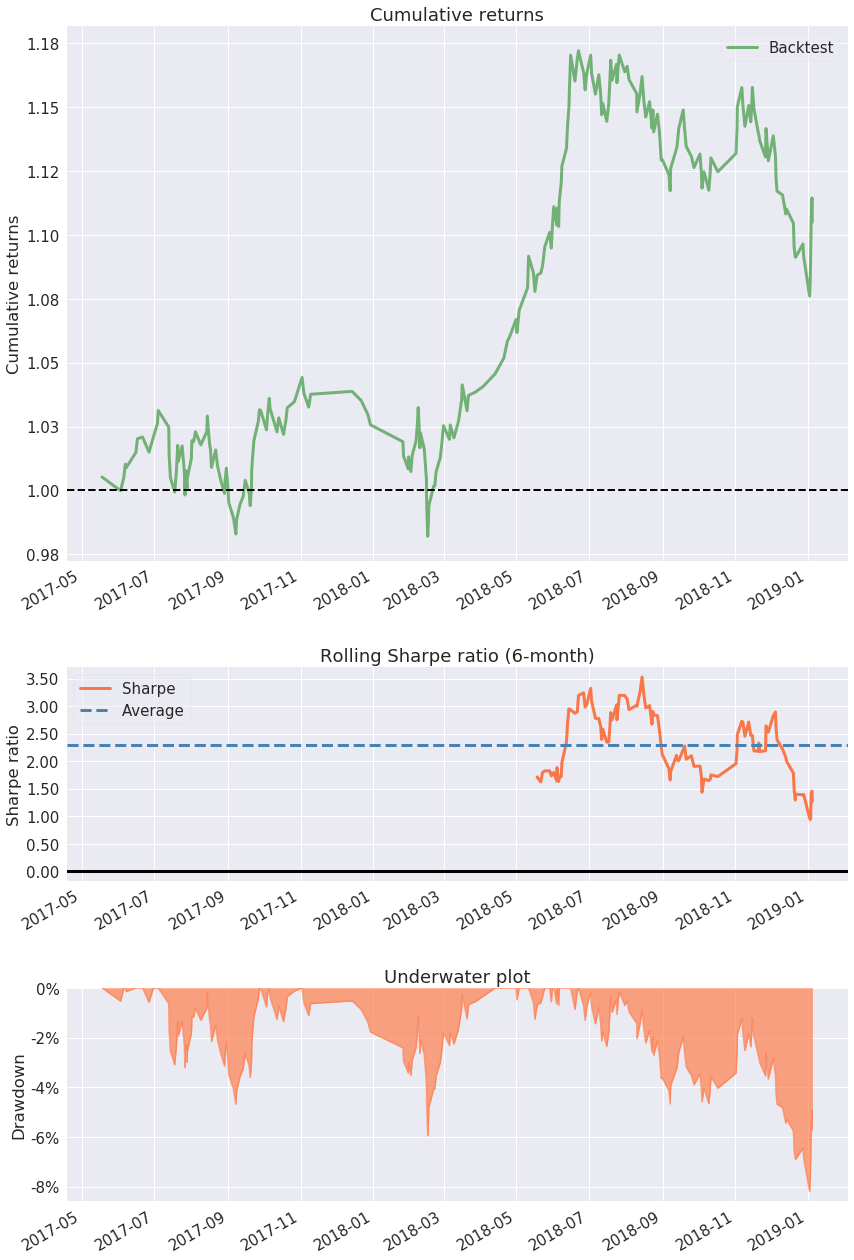

In [42]:
cols = features['top_feat_RF']
model = models['Scaler->SVM']
validation = True
if validation:
    get_pyfolio_simple_tear_sheet(model,X_train[cols], Y_train, X_valid[cols], Y_valid, target_rtns_valid)
else:
    get_pyfolio_simple_tear_sheet(model,X_valid[cols], Y_valid, X_test[cols], Y_test, target_rtns_test)

### Conclusion
We need to do thorough testing of all models for selected currency pairs to choose the right model/ensemple. As a criteria it may be worth to use Sharp Ratio as it incorporates both return and volatility.
Part of the code from this notebook will be moved into a wqu package for further use.